# EFC2: MNIST MLP and CNN Classifier

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

# 0. Dataset and Description

**Name:**  MNIST  
**Description:** this notebook uses the MNIST database to perform an Multilayer Perceptron (MLP) classifier and a Convolutional Neural Network (CNN) with the aim of image classification of handwritten digits. We use the validation set to choose the hyperparameters.

# 1. Libraries and packages

## 1.1 Install packages

In [0]:
!pip install -q    \
    numpy          \
    sklearn        \
    matplotlib     \
    tensorflow      \
    tensorflow-determinism

## 1.2 Import libraries

In [0]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import tensorflow as tf
import os
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Check Device

In [3]:
# choose between CPU and GPU
device = tf.device('/cpu:0')
if tf.config.list_physical_devices('GPU'):
    device = tf.device('/device:GPU:0')
#    device_model = torch.cuda.get_device_name(0)
#    device_memory = torch.cuda.get_device_properties(device).total_memory / 1e9
    device_number = len(tf.config.experimental.list_physical_devices('GPU'))
    #----------------------------
    #from tensorflow.python.client import device_lib
    #device_lib.list_local_devices()
    #----------------------------
    print('Device: gpu')
    #print('GPU model:', device_model)
    #print('GPU memory: {0:.2f} GB'.format(device_memory))
    print("GPUs available: ", device_number)
    print('#-------------------')
print('CPU cores:', cpu_count())

Device: gpu
GPUs available:  1
#-------------------
CPU cores: 2


# 2. MLP approach

## 2.1 Professor's reference implementation

The following code is the professor's suggestion with the following modifications:
 - encapsulated all code inside a function;
 - included seed as function parameter;
 - included device as parameter (to run on CPU/GPU);
 - set NumPy and TensorFlow seed;
 - removed the 'import' lines;
 - added 'verbose = 0' during training and evaluation;
 - included a 'print' section;
 - inserted comments;
 - commented the part where the model and its weigths are saved in a file


In [0]:
def mlp_train_professor(device, seed=42):
    with device:
        # define RNG seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        #----------------------------
        # getting the dataset
        mnist = tf.keras.datasets.mnist
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
        #----------------------------
        # defining the model
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
        #----------------------------
        # training configuration
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        #----------------------------
        # training
        model.fit(x_train, y_train, epochs=5, verbose=0)
        #----------------------------
        # evaluation
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        #----------------------------
        # saving the model and weights
        #model_json = model.to_json()
        #json_file = open("model_MLP.json", "w")
        #json_file.write(model_json)
        #json_file.close()
        #model.save_weights("model_MLP.h5")
        #print("Model save")
        #----------------------------
        print('seed = ', str(seed), '; '
            'loss = ', '{0:.4f}'.format(loss), '; '
            'accuracy = ', '{0:.4f}'.format(accuracy), sep='')
        #----------------------------
        return loss, accuracy

Running the model 10 times to get an average loss and an average accuracy

In [5]:
seeds = range(10)
loss_his_mlp_prof = []
acc_his_mlp_prof = []
#----------------------------
for seed in seeds:
    loss, acc = mlp_train_professor(device, seed=seed)
    # append both loss and accuracy in a list for comparison
    loss_his_mlp_prof.append(loss)
    acc_his_mlp_prof.append(acc)

seed = 0; loss = 0.0658; accuracy = 0.9807
seed = 1; loss = 0.0655; accuracy = 0.9790
seed = 2; loss = 0.0683; accuracy = 0.9793
seed = 3; loss = 0.0663; accuracy = 0.9794
seed = 4; loss = 0.0666; accuracy = 0.9811
seed = 5; loss = 0.0704; accuracy = 0.9784
seed = 6; loss = 0.0709; accuracy = 0.9785
seed = 7; loss = 0.0637; accuracy = 0.9803
seed = 8; loss = 0.0673; accuracy = 0.9798
seed = 9; loss = 0.0719; accuracy = 0.9774


Getting the average loss and accuracy of the 10 executions

In [6]:
print('Loss average = {0:.4f}'.format(np.mean(loss_his_mlp_prof)))
print('Accuracy average = {0:.4f}'.format(np.mean(acc_his_mlp_prof)))

Loss average = 0.0677
Accuracy average = 0.9794


## 2.2 My implementation

In [0]:
def mlp_train(device, seed=42, verbose=False):
    with device:
        # define RNG seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        #----------------------------
        # getting the dataset
        mnist = tf.keras.datasets.mnist
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
        #----------------------------
        # train-dev split
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_train,
            y_train,
            test_size=0.2,
            random_state=seed,
            shuffle=True)
        #----------------------------
        # defining the model
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                800,
                #kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=seed),
                kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                bias_initializer='zeros',
                activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
        #----------------------------
        # early-stopping
        callback_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            mode='min',
            verbose=verbose,
            restore_best_weights=True
        )
        #----------------------------
        # optmizer
        opt_adam = tf.keras.optimizers.Adam(learning_rate=5e-4)
        #----------------------------
        # learning rate schedule
        # lr = 0.0005 for the first 15 epochs and decreases exponentially after that
        def scheduler(epoch):
            if epoch < 15:
                return 0.0005
            else:
                return 0.0005 * tf.math.exp(0.05 * (15 - epoch))
        callback_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
        #----------------------------
        # training configuration
        model.compile(
            optimizer=opt_adam,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        #----------------------------
        # training
        model.fit(x_train, y_train, 
            #batch_size=512,
            batch_size=128,
            epochs=100, 
            verbose=verbose,
            callbacks=[callback_stop, callback_schedule], 
            validation_data=(x_dev, y_dev))
        #----------------------------
        # evaluation
        loss, accuracy = model.evaluate(x_test, y_test, verbose=verbose)
        #----------------------------
        # saving the model and weights
        #model_json = model.to_json()
        #json_file = open("model_MLP.json", "w")
        #json_file.write(model_json)
        #json_file.close()
        #model.save_weights("model_MLP.h5")
        #print("Model save")
        #----------------------------
        print('seed = ', str(seed), '; '
            'loss = ', '{0:.4f}'.format(loss), '; '
            'accuracy = ', '{0:.4f}'.format(accuracy), sep='')
        #----------------------------
        return loss, accuracy

Running the model 10 times to get an average loss and accuracy

In [8]:
seeds = range(10)
loss_his_mlp = []
acc_his_mlp = []
#----------------------------
for seed in seeds:
    loss, acc = mlp_train(device, seed=seed)
    # append both loss and accuracy in a list for comparison
    loss_his_mlp.append(loss)
    acc_his_mlp.append(acc)

seed = 0; loss = 0.0566; accuracy = 0.9837
seed = 1; loss = 0.0590; accuracy = 0.9821
seed = 2; loss = 0.0571; accuracy = 0.9841
seed = 3; loss = 0.0566; accuracy = 0.9838
seed = 4; loss = 0.0567; accuracy = 0.9836
seed = 5; loss = 0.0566; accuracy = 0.9845
seed = 6; loss = 0.0554; accuracy = 0.9830
seed = 7; loss = 0.0589; accuracy = 0.9834
seed = 8; loss = 0.0573; accuracy = 0.9824
seed = 9; loss = 0.0571; accuracy = 0.9831


Getting the average loss and accuracy of the 10 executions

In [9]:
print('Loss average = {0:.4f}'.format(np.mean(loss_his_mlp)))
print('Accuracy average = {0:.4f}'.format(np.mean(acc_his_mlp)))

Loss average = 0.0571
Accuracy average = 0.9834


## 2.3 Results comparison

The next table compares the accuracy metric on the test set of the two implementations: the professor's reference implementation and the developed implementation.

| seed | reference acc | developed acc |
|:---: | :-----------: | :-----------: |
|   0  |     0.9807    |     0.9837    |
|   1  |     0.9790    |     0.9821    |
|   2  |     0.9793    |     0.9841    |
|   3  |     0.9794    |     0.9838    |
|   4  |     0.9811    |     0.9836    |
|   5  |     0.9784    |     0.9845    |
|   6  |     0.9785    |     0.9830    |
|   7  |     0.9803    |     0.9834    |
|   8  |     0.9798    |     0.9824    |
|   9  |     0.9774    |     0.9831    |

The next table shows the mean of 10 trainings of each implementation's accuracy:

|      | reference acc | developed acc |
|:---: | :-----------: | :-----------: |
| mean |    0.9794     |    0.9834     |

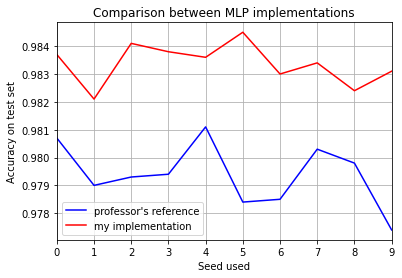

In [10]:
# plot both implementation's accuracy for different seeds
plt.plot(acc_his_mlp_prof, label='professor\'s reference', color='blue')
plt.plot(acc_his_mlp, label='my implementation', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Seed used')
plt.ylabel('Accuracy on test set')
# title
plt.title('Comparison between MLP implementations')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

## 2.4 How I achieved my final network setup

### 2.4.1 Modifications


Obs.: The accuracy reported was obtained with the test set after the training. The random seed used for all experiments was 42.

___
**1.** Increased neurons of hidden layer to 800. Changed weights initialization to a normal distribution with standard deviation of 0.05. Final accuracy = 0.9767.

**2.** Changed the number of epochs to 10. Final accuracy = 0.9821.

**3.** Split the trainig set (60,000 samples) in training (48,000 samples) and development set (12,000 samples). Added early-stopping with patience of 3 epochs. Final accuracy = 0.9803.

**4.** Set learning rate of Adam optimizer to 0.0005. Final accuracy = 0.9819.

**5.** Changed weights initialization to normal Glorot. Final accuracy = 0.9810.

**6.** Increased batch size to 128. Final accuracy = 0.9817.

**7.** Added a schedule to decrease the learning rate exponentially after 15 epochs. Also changed early stop to return the best model and increased the patience to 10 epochs. Final accuracy = 0.9825.

**8.** Increased batch size to 512. Final accuracy = 0.9819.
___

Since the training accuracy was already in a very high value (0.9964), I decided to stop the experiments here. Before training the model 10 times for more stable results, the batch size was changed back to 128.

### 2.4.2 References

Yann LeCun has compiled in his own page [1] a list with results, error obtained and paper associated, considering the MNIST dataset. 

The best results (less than 1% error) all use elastic distortions on the images (except [2], that uses unsupervised pre-training). The best results without using distortions and using only a neural network approach is [3] and a 3-Layer NN by Hinton. Since [3] uses only 2 layers, I decided to use as a guide to my solution.

This way, it was choosen 800 neurons for the hidden layer and a weight initialization considering a normal distribution with standard deviation of 0.05, as described in the step 1 of the previous cell. The following modifications were empirical and based on 'trial and error' approach.
___
[1] http://yann.lecun.com/exdb/mnist/  
[2] Deng, Li / Yu, Dong (2011): "Deep convex net: a scalable architecture for speech pattern classification", In INTERSPEECH-2011, 2285-2288.  
[3] Simard, Patrice Y., David Steinkraus, and John C. Platt. "Best practices for convolutional neural networks applied to visual document analysis." Icdar. Vol. 3. No. 2003. 2003.

# 3. CNN approach

## 3.1 Professor's reference implementation

Just like the MLP approach, the following code is the professor's suggestion with the same modifications applied before.

In [0]:
def cnn_train_professor(device, seed=42):
    with device:
        # define RNG seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        #----------------------------
        # getting the dataset
        mnist = tf.keras.datasets.mnist
        (x_train, y_train),(x_test, y_test) = mnist.load_data()
        # reshape to be [samples][width][height][pixels]
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        x_train, x_test = x_train / 255.0, x_test / 255.0
        #----------------------------
        # defining the model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        #----------------------------
        # defining the model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        #----------------------------
        # training
        model.fit(x_train, y_train, epochs=5, verbose=0)
        #----------------------------
        # evaluation
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        #----------------------------
        # saving the model and weights
        #model_json = model.to_json()
        #json_file = open("model_CNN.json", "w")
        #json_file.write(model_json)
        #json_file.close()
        #model.save_weights("model_CNN.h5")
        #print("Model saved to disk")
        #os.getcwd()
        #----------------------------
        print('seed = ', str(seed), '; ',
            'loss = ', '{0:.4f}'.format(loss), '; ',
            'accuracy = ', '{0:.4f}'.format(accuracy), sep='')
        #----------------------------
        return loss, accuracy

Running the model 10 times to get an average loss and accuracy

In [12]:
seeds = range(10)
loss_his_cnn_prof = []
acc_his_cnn_prof = []
#----------------------------
for seed in seeds:
    loss, acc = cnn_train_professor(device, seed=seed)
    # append both loss and accuracy in a list for comparison
    loss_his_cnn_prof.append(loss)
    acc_his_cnn_prof.append(acc)

seed = 0; loss = 0.0345; accuracy = 0.9893
seed = 1; loss = 0.0286; accuracy = 0.9906
seed = 2; loss = 0.0268; accuracy = 0.9919
seed = 3; loss = 0.0280; accuracy = 0.9901
seed = 4; loss = 0.0348; accuracy = 0.9894
seed = 5; loss = 0.0320; accuracy = 0.9912
seed = 6; loss = 0.0291; accuracy = 0.9907
seed = 7; loss = 0.0296; accuracy = 0.9918
seed = 8; loss = 0.0258; accuracy = 0.9911
seed = 9; loss = 0.0291; accuracy = 0.9910


Getting the average loss and accuracy of the 10 executions

In [13]:
print('Loss average = {0:.4f}'.format(np.mean(loss_his_cnn_prof)))
print('Accuracy average = {0:.4f}'.format(np.mean(acc_his_cnn_prof)))

Loss average = 0.0298
Accuracy average = 0.9907


## 3.2 My implementation

In [0]:
def cnn_train(device, seed=42, verbose=False):
    with device:
        # define RNG seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        #----------------------------
        # getting the dataset
        mnist = tf.keras.datasets.mnist
        (x_train, y_train),(x_test, y_test) = mnist.load_data()
        # reshape to be [samples][width][height][pixels]
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        x_train, x_test = x_train / 255.0, x_test / 255.0
        #----------------------------
        # train-dev split
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_train,
            y_train,
            test_size=0.2,
            random_state=seed,
            shuffle=True)
        #----------------------------
        # defining the model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.50))
        #--------------
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.50))
        #--------------
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        #----------------------------
        # early-stopping
        callback_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5,
            mode='min',
            verbose=verbose,
            restore_best_weights=True
        )
        #----------------------------
        # optmizer
        opt_adam = tf.keras.optimizers.Adam(learning_rate=5e-4)
        #----------------------------
        # learning rate schedule
        # lr = 0.0005 for the first 20 epochs and decreases exponentially after that
        def scheduler(epoch):
            if epoch < 20:
                return 0.0005
            else:
                return 0.0005 * tf.math.exp(0.1 * (20 - epoch))
        callback_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
        #----------------------------
        # defining the model
        model.compile(
            optimizer=opt_adam,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        #----------------------------
        # training
        model.fit(x_train, y_train, 
            epochs=100, 
            batch_size=64,
            callbacks=[callback_stop, callback_schedule], 
            validation_data=(x_dev, y_dev),
            verbose=verbose,
        )
        #----------------------------
        # evaluation
        loss, accuracy = model.evaluate(x_test, y_test, verbose=verbose)
        #----------------------------
        # saving the model and weights
        #model_json = model.to_json()
        #json_file = open("model_CNN.json", "w")
        #json_file.write(model_json)
        #json_file.close()
        #model.save_weights("model_CNN.h5")
        #print("Model saved to disk")
        #os.getcwd()
        #----------------------------
        print('seed = ', str(seed), '; ',
            'epochs = ', str(callback_stop.stopped_epoch - callback_stop.patience + 1), '; ', 
            'loss = ', '{0:.4f}'.format(loss), '; ',
            'accuracy = ', '{0:.4f}'.format(accuracy), sep='')
        #----------------------------
        return loss, accuracy


Running the model 10 times to get an average loss and accuracy

In [15]:
seeds = range(10)
loss_his_cnn = []
acc_his_cnn = []
#----------------------------
for seed in seeds:
    loss, acc = cnn_train(device, seed=seed)
    # append both loss and accuracy in a list for comparison
    loss_his_cnn.append(loss)
    acc_his_cnn.append(acc)

seed = 0; epochs = 33; loss = 0.0204; accuracy = 0.9923
seed = 1; epochs = 27; loss = 0.0226; accuracy = 0.9923
seed = 2; epochs = 29; loss = 0.0213; accuracy = 0.9937
seed = 3; epochs = 41; loss = 0.0171; accuracy = 0.9945
seed = 4; epochs = 32; loss = 0.0197; accuracy = 0.9936
seed = 5; epochs = 48; loss = 0.0207; accuracy = 0.9927
seed = 6; epochs = 15; loss = 0.0250; accuracy = 0.9913
seed = 7; epochs = 31; loss = 0.0222; accuracy = 0.9917
seed = 8; epochs = 41; loss = 0.0203; accuracy = 0.9927
seed = 9; epochs = 44; loss = 0.0194; accuracy = 0.9938


Getting the average loss and accuracy of the 10 executions

In [16]:
print('Loss average = {0:.4f}'.format(np.mean(loss_his_cnn)))
print('Accuracy average = {0:.4f}'.format(np.mean(acc_his_cnn)))

Loss average = 0.0209
Accuracy average = 0.9929


## 3.3 Results comparison

The next table compares the accuracy metric on the test set of the two implementations: the professor's reference implementation and the developed implementation.

| seed | reference acc | developed acc |
|:---: | :-----------: | :-----------: |
|   0  |    0.9893     |     0.9923    |
|   1  |    0.9906     |     0.9923    |
|   2  |    0.9919     |     0.9937    |
|   3  |    0.9901     |     0.9945    |
|   4  |    0.9894     |     0.9936    |
|   5  |    0.9912     |     0.9927    |
|   6  |    0.9907     |     0.9913    |
|   7  |    0.9918     |     0.9917    |
|   8  |    0.9911     |     0.9927    |
|   9  |    0.9910     |     0.9938    |

The next table shows the mean of 10 trainings of each implementation's accuracy:

|      | reference acc | developed acc |
|:---: | :-----------: | :-----------: |
| mean |    0.9907     |     0.9929    |

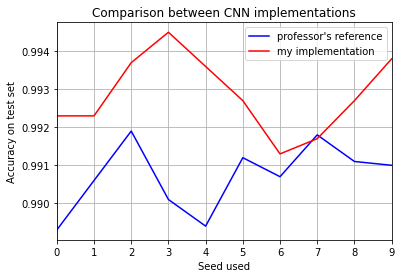

In [17]:
# plot both implementation's accuracy for different seeds
plt.plot(acc_his_cnn_prof, label='professor\'s reference', color='blue')
plt.plot(acc_his_cnn, label='my implementation', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Seed used')
plt.ylabel('Accuracy on test set')
# title
plt.title('Comparison between CNN implementations')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

## 3.4 How I achieved my final network setup

### 3.4.1 Modifications


Obs.: The accuracy reported was obtained with the test set after the training. The random seed used for all experiments was 42.

___
**1.** The first execution was done without any changes. Accuracy = 0.9902.

**2.** Increased dropout from 25% to 50% after second convolutional layer. Final accuracy = 0.9912.

**3.** Added max pooling layer and dropout of 50% after first convolutional layer. Final accuracy = 0.9908.

**4.** Increased number of epochs from 5 to 10. Final accuracy = 0.9914.

**5.** Split the trainig set (60,000 samples) in training (48,000 samples) and development set (12,000 samples). Added early-stopping with patience of 5 epochs. Final accuracy = 0.9928.

**6.** Added a schedule to decrease the learning rate exponentially after 20 epochs. Final accuracy = 0.9934.

**7.** Increased batch size to 64. Final accuracy = 0.9940.

### 3.4.2 References

The same page from Yann LeCun cited before [1] has also results considering convolutional neural networks. However, almost all of the ones with the best results use some kind of distortion (elastic, affine) or use unsupervised pretraining.

This way, the modifications were empirical and based on a 'trial and error' approach, considering some well known practices (ex: using development set, early-stopping, learning rate schedule) and trying not to change the network architecture (kernel size, layers, etc).
___
[1] http://yann.lecun.com/exdb/mnist/

# 4. Comparison between different approaches

The next table compares the accuracy on the test set for the following approaches:
 - Linear Classifier (EFC1, Q1)
 - Extreme Learning Machine (EFC2, Q2)
 - Multilayer Perceptron (EFC2, Q3)
 - Convolutional Neural Network (EFC2, Q4)

| approach | accuracy |
|:-------: | :------: |
|  Linear  |  0.8647  |
|   ELM    |  0.9194  |
|   MLP    |  0.9834  |
|   CNN    |  0.9929  |

# End of the notebook